In [1]:
import pandas as pd
import os, time
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random 

In [2]:
#Set seed value
seed_value = 43
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
#numpy seed
np.random.seed(seed_value)
#Tf seed
tf.random.set_seed(seed_value)
tf.keras.backend.clear_session()

In [3]:
# Check TensorFlow's version
print("TensorFlow Version:", tf.__version__)

# Check available devices
print("Available devices:", tf.config.list_physical_devices())

# Test if the GPU is recognized
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

TensorFlow Version: 2.10.1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0


In [4]:
#Hyper params
split = 0.8
height, width = 240, 320
LR = 0.0001
BATCH_SIZE = 2

In [5]:
train_df = pd.read_csv('data/nyu2_train.csv',header=None)
test = pd.read_csv('data/nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
train_split = int(len(train_df)*split)

train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

(40550, 10138)

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,240)):
        # for reproducibility
        np.random.seed(43)
        # dataframe containing the subset of image and depth pairs
        self.df = dataframe
        # chosen Height and Width of the RGB image
        self.height, self.width = dim
        # choice of shuffling the data
        self.shuffle = shuffle
        self.batch_size = batch_size
        # unique set of RGB images
        self.ids = dataframe['image'].unique()
        # Map the image with depth maps
        self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
        self.on_epoch_end()

    def __len__(self):
        '''
        Returns the length of dataset.
        '''
        return len(self.df) // self.batch_size

    def on_epoch_end(self):
        '''
        Shuffles the data at the end of every epoch
        '''
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self,index):
        '''
        returns the batch of image and depth pairs 
        '''
        # select the batch of pair indexes 
        idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        # randomly select whether to flip the image
        flip = np.random.choice([True, False])
        # select the image id's for the above indexes
        query_imgs = [self.ids[idx] for idx in idxs]
        # select corresponding depth pair for the image
        target_imgs = [self.imgtodpth[img] for img in query_imgs]
        # preprocess the image 
        processed_query_img = self._preprocess_image(query_imgs, flip)
        # preprocess the depth map
        processed_depth_img = self._preprocess_depth(target_imgs, flip)
        return processed_query_img, processed_depth_img

    def _preprocess_image(self,images, flip):
        '''
        Resize, Normalize and randomly Augments the image set. 
        '''
        # placeholder for storing the processed images
        processed = []
        for img in images:
            # resize the image
            resized_img = cv2.resize(cv2.imread(img),(self.height,self.width)).astype(np.float32)
            # normalize the image to {0,1}
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            # flip the image horizontally
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            # finally append each image
            processed.append(scaled_img)
        return np.array(processed)

    def _preprocess_depth(self,images, flip):
        '''
        Resize, Normalize and randomly Augments the depth maps.
        '''
        # placeholder for storing the processed depth maps
        processed = []
        for img in images:
            # resize the depth map
            resized_img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY),(width//2,height//2)).astype(np.float32)
            # normalize it to range {0,1}
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            # flip the image horizontally
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
            scaled_img = np.expand_dims(scaled_img, axis=-1)
            # finally append the image
            processed.append(scaled_img)
        return np.array(processed)

In [7]:
train_generator = DataGenerator(train, batch_size=BATCH_SIZE, shuffle=True, dim=(width, height))
val_generator = DataGenerator(validation, batch_size=BATCH_SIZE, shuffle=False, dim=(width, height))
test_generator = DataGenerator(test, batch_size=10, shuffle=False, dim=(width, height))
print(len(train_generator), len(val_generator), len(test_generator))

20275 5069 65


In [8]:
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

(2, 240, 320, 3) (2, 120, 160, 1)


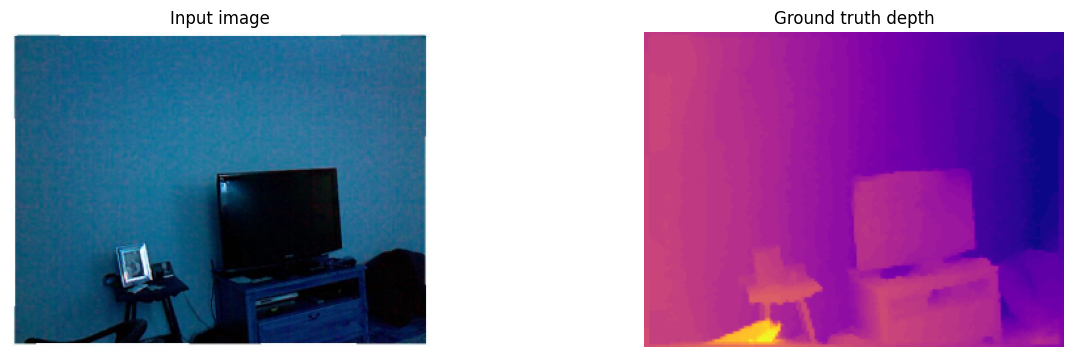

In [9]:
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,2,2):
  image = images[i]
  depth = depths[i].squeeze(-1)
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Ground truth depth')

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU
from tensorflow.keras.models import Model

# Define the input shape for the model, with height, width, and 3 channels (RGB)
input_shape = (height, width, 3)

# Load the pre-trained MobileNetV2 model without the top layer, using weights from ImageNet
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', layers=tf.keras.layers, input_tensor=Input(shape=input_shape))

# Get the output of a specific layer from the MobileNetV2 model to use as the encoded features
encoder_output = base_model.get_layer('block_13_expand_relu').output

# Apply a depthwise convolution to the encoder output
bottleneck = DepthwiseConv2D(kernel_size=(1, 1), padding='same')(encoder_output)
# Apply ReLU activation to the bottleneck layer
bottleneck = ReLU()(bottleneck)

# Function for upsampling that takes an input tensor, a skip connection tensor, and the number of filters for the convolution
def upsampling(input_tensor, skip_tensor, num_filters):
    # Apply upsampling (increase size) with bilinear interpolation
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(input_tensor)
    # Concatenate the upsampled tensor with the skip connection tensor
    x = Concatenate()([x, skip_tensor])
    # Apply a depthwise convolution followed by batch normalization
    x = DepthwiseConv2D(kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    # Apply a standard convolution followed by batch normalization
    x = Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    # Apply LeakyReLU activation to the layer
    return LeakyReLU(alpha=0.2)(x)

# Perform upsampling with outputs from specific layers of MobileNetV2
x = upsampling(bottleneck, base_model.get_layer('block_6_expand_relu').output, 16)
x = upsampling(x, base_model.get_layer('block_3_expand_relu').output, 12)
x = upsampling(x, base_model.get_layer('block_1_expand_relu').output, 8)

# Final convolution layer to produce the output with sigmoid activation
output_layer = Conv2D(filters=1, activation='sigmoid', kernel_size=(3, 3), padding='same')(x)

# Create the model by defining the inputs and outputs
model = Model(inputs=base_model.input, outputs=output_layer)

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 120, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 120, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.losses import mean_absolute_error

def loss_function(y_true, y_pred):
    # Cosine distance loss
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # edge loss for sharp edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # structural similarity loss
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

    # weightage
    w1, w2, w3 = 1.0, 1.0, 0.1
    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#optimizer
opt = tf.keras.optimizers.Adam(learning_rate=LR, amsgrad=False,)

# accuracy function
def accuracy_function(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# save model frequently for later use.
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/monocular-depth-estimation2.0',
                                                save_best_only=True,
                                                verbose=1)
# Learning rate scheduler
def polynomial_decay(epoch):
    max_epochs = 20
    base_lr =  0.0001
    power = 1.0
    lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
    return lr

callbacks = [checkpoint]

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [12]:
# Start training the model
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function, mae, mse])
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
20274/20275 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy_function: 0.7920 - mae: 0.1432 - mse: 0.0339
Epoch 1: val_loss improved from inf to 0.16853, saving model to models\monocular-depth-estimation2.0


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 1097s 54ms/step - loss: 0.1940 - accuracy_function: 0.7920 - mae: 0.1432 - mse: 0.0339 - val_loss: 0.1685 - val_accuracy_function: 0.8216 - val_mae: 0.1267 - val_mse: 0.0269
Epoch 2/20
20274/20275 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy_function: 0.8315 - mae: 0.1179 - mse: 0.0247
Epoch 2: val_loss improved from 0.16853 to 0.15894, saving model to models\monocular-depth-estimation2.0


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 947s 47ms/step - loss: 0.1589 - accuracy_function: 0.8315 - mae: 0.1179 - mse: 0.0247 - val_loss: 0.1589 - val_accuracy_function: 0.8365 - val_mae: 0.1167 - val_mse: 0.0237
Epoch 3/20
20274/20275 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy_function: 0.8499 - mae: 0.1070 - mse: 0.0211
Epoch 3: val_loss improved from 0.15894 to 0.15255, saving model to models\monocular-depth-estimation2.0


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 946s 47ms/step - loss: 0.1473 - accuracy_function: 0.8499 - mae: 0.1070 - mse: 0.0211 - val_loss: 0.1526 - val_accuracy_function: 0.8450 - val_mae: 0.1132 - val_mse: 0.0224
Epoch 4/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1399 - accuracy_function: 0.8635 - mae: 0.0993 - mse: 0.0186
Epoch 4: val_loss improved from 0.15255 to 0.14831, saving model to models\monocular-depth-estimation2.0


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 940s 46ms/step - loss: 0.1399 - accuracy_function: 0.8635 - mae: 0.0993 - mse: 0.0186 - val_loss: 0.1483 - val_accuracy_function: 0.8504 - val_mae: 0.1085 - val_mse: 0.0214
Epoch 5/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1347 - accuracy_function: 0.8729 - mae: 0.0938 - mse: 0.0169
Epoch 5: val_loss did not improve from 0.14831
20275/20275 [==============================] - 934s 46ms/step - loss: 0.1347 - accuracy_function: 0.8729 - mae: 0.0938 - mse: 0.0169 - val_loss: 0.1492 - val_accuracy_function: 0.8431 - val_mae: 0.1116 - val_mse: 0.0224
Epoch 6/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1306 - accuracy_function: 0.8801 - mae: 0.0892 - mse: 0.0155
Epoch 6: val_loss improved from 0.14831 to 0.14324, saving model to models\monocular-depth-estimation2.0


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 944s 47ms/step - loss: 0.1306 - accuracy_function: 0.8801 - mae: 0.0892 - mse: 0.0155 - val_loss: 0.1432 - val_accuracy_function: 0.8601 - val_mae: 0.1042 - val_mse: 0.0196
Epoch 7/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1275 - accuracy_function: 0.8860 - mae: 0.0858 - mse: 0.0144
Epoch 7: val_loss did not improve from 0.14324
20275/20275 [==============================] - 941s 46ms/step - loss: 0.1275 - accuracy_function: 0.8860 - mae: 0.0858 - mse: 0.0144 - val_loss: 0.1481 - val_accuracy_function: 0.8567 - val_mae: 0.1122 - val_mse: 0.0215
Epoch 8/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1246 - accuracy_function: 0.8908 - mae: 0.0825 - mse: 0.0135
Epoch 8: val_loss improved from 0.14324 to 0.13871, saving model to models\monocular-depth-estimation2.0


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 954s 47ms/step - loss: 0.1246 - accuracy_function: 0.8908 - mae: 0.0825 - mse: 0.0135 - val_loss: 0.1387 - val_accuracy_function: 0.8641 - val_mae: 0.1023 - val_mse: 0.0193
Epoch 9/20
20274/20275 [============================>.] - ETA: 0s - loss: 0.1223 - accuracy_function: 0.8944 - mae: 0.0801 - mse: 0.0128
Epoch 9: val_loss did not improve from 0.13871
20275/20275 [==============================] - 938s 46ms/step - loss: 0.1223 - accuracy_function: 0.8944 - mae: 0.0801 - mse: 0.0128 - val_loss: 0.1437 - val_accuracy_function: 0.8676 - val_mae: 0.1047 - val_mse: 0.0189
Epoch 10/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1205 - accuracy_function: 0.8969 - mae: 0.0783 - mse: 0.0123
Epoch 10: val_loss did not improve from 0.13871
20275/20275 [==============================] - 933s 46ms/step - loss: 0.1205 - accuracy_function: 0.8969 - mae: 0.0783 - mse: 0.0123 - val_loss: 0.1387 - val_accuracy_function: 0.8688 - val_

INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 944s 47ms/step - loss: 0.1188 - accuracy_function: 0.8996 - mae: 0.0764 - mse: 0.0117 - val_loss: 0.1361 - val_accuracy_function: 0.8776 - val_mae: 0.0963 - val_mse: 0.0162
Epoch 12/20
20274/20275 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy_function: 0.9023 - mae: 0.0746 - mse: 0.0113
Epoch 12: val_loss did not improve from 0.13607
20275/20275 [==============================] - 930s 46ms/step - loss: 0.1171 - accuracy_function: 0.9023 - mae: 0.0746 - mse: 0.0113 - val_loss: 0.1376 - val_accuracy_function: 0.8738 - val_mae: 0.1009 - val_mse: 0.0178
Epoch 13/20
20274/20275 [============================>.] - ETA: 0s - loss: 0.1158 - accuracy_function: 0.9047 - mae: 0.0731 - mse: 0.0108
Epoch 13: val_loss did not improve from 0.13607
20275/20275 [==============================] - 940s 46ms/step - loss: 0.1158 - accuracy_function: 0.9047 - mae: 0.0731 - mse: 0.0108 - val_loss: 0.1388 - val_accuracy_function: 0.8723 - va

INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 951s 47ms/step - loss: 0.1146 - accuracy_function: 0.9060 - mae: 0.0719 - mse: 0.0105 - val_loss: 0.1339 - val_accuracy_function: 0.8719 - val_mae: 0.0998 - val_mse: 0.0181
Epoch 15/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1135 - accuracy_function: 0.9075 - mae: 0.0709 - mse: 0.0103
Epoch 15: val_loss improved from 0.13392 to 0.13365, saving model to models\monocular-depth-estimation2.0


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 950s 47ms/step - loss: 0.1135 - accuracy_function: 0.9075 - mae: 0.0709 - mse: 0.0103 - val_loss: 0.1336 - val_accuracy_function: 0.8754 - val_mae: 0.0976 - val_mse: 0.0174
Epoch 16/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1126 - accuracy_function: 0.9088 - mae: 0.0701 - mse: 0.0101
Epoch 16: val_loss did not improve from 0.13365
20275/20275 [==============================] - 934s 46ms/step - loss: 0.1126 - accuracy_function: 0.9088 - mae: 0.0701 - mse: 0.0101 - val_loss: 0.1364 - val_accuracy_function: 0.8815 - val_mae: 0.0985 - val_mse: 0.0165
Epoch 17/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1116 - accuracy_function: 0.9097 - mae: 0.0692 - mse: 0.0098
Epoch 17: val_loss did not improve from 0.13365
20275/20275 [==============================] - 938s 46ms/step - loss: 0.1116 - accuracy_function: 0.9097 - mae: 0.0692 - mse: 0.0098 - val_loss: 0.1373 - val_accuracy_function: 0.8707 - va

INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 957s 47ms/step - loss: 0.1108 - accuracy_function: 0.9109 - mae: 0.0683 - mse: 0.0096 - val_loss: 0.1325 - val_accuracy_function: 0.8693 - val_mae: 0.1009 - val_mse: 0.0189
Epoch 19/20
20275/20275 [==============================] - ETA: 0s - loss: 0.1099 - accuracy_function: 0.9120 - mae: 0.0676 - mse: 0.0094
Epoch 19: val_loss improved from 0.13254 to 0.13136, saving model to models\monocular-depth-estimation2.0


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 953s 47ms/step - loss: 0.1099 - accuracy_function: 0.9120 - mae: 0.0676 - mse: 0.0094 - val_loss: 0.1314 - val_accuracy_function: 0.8836 - val_mae: 0.0936 - val_mse: 0.0159
Epoch 20/20
20274/20275 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy_function: 0.9132 - mae: 0.0669 - mse: 0.0092
Epoch 20: val_loss improved from 0.13136 to 0.13016, saving model to models\monocular-depth-estimation2.0


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


INFO:tensorflow:Assets written to: models\monocular-depth-estimation2.0\assets


20275/20275 [==============================] - 950s 47ms/step - loss: 0.1091 - accuracy_function: 0.9132 - mae: 0.0669 - mse: 0.0092 - val_loss: 0.1302 - val_accuracy_function: 0.8860 - val_mae: 0.0931 - val_mse: 0.0157


In [13]:
# Evaluating the model on the test dataset.
model.evaluate(test_generator)

65/65 [==============================] - 18s 265ms/step - loss: 0.2253 - accuracy_function: 0.7890 - mae: 0.1495 - mse: 0.0369


[0.22526970505714417,
 0.788953423500061,
 0.14950311183929443,
 0.03694460913538933]

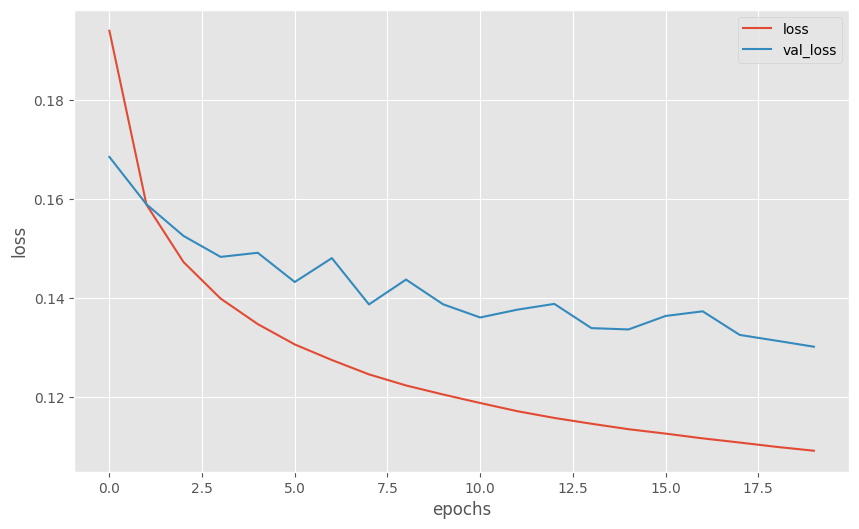

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
# using the style for the plot
plt.style.use('ggplot')
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

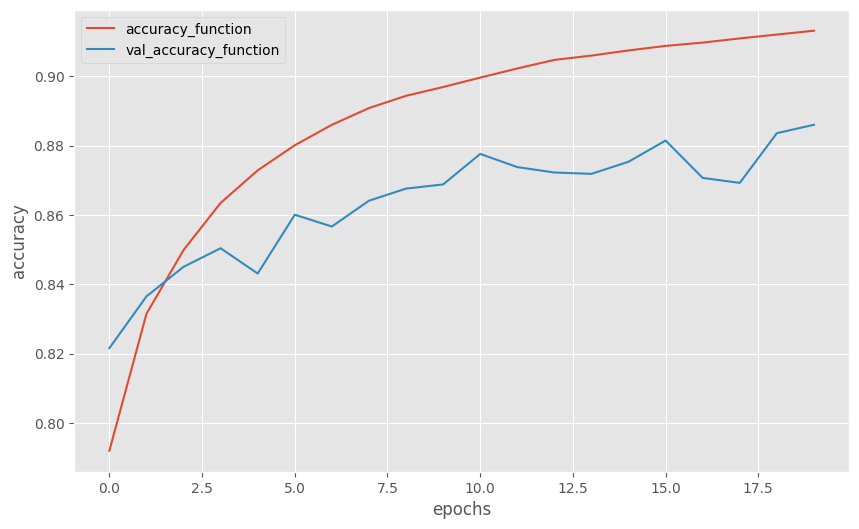

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy_function', 'val_accuracy_function']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [16]:
images,labels = next(iter(test_generator))
preds = model.predict(images)

1/1 [==============================] - 1s 722ms/step


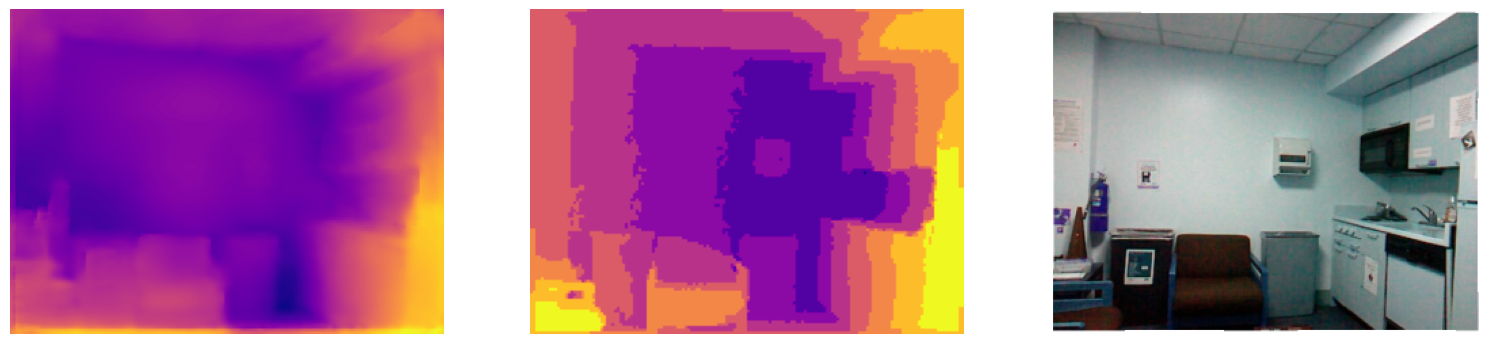

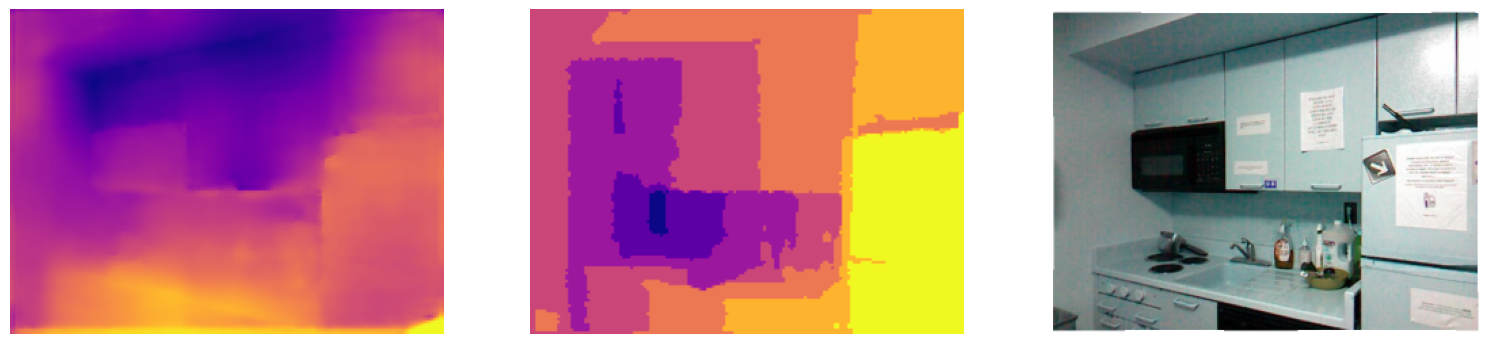

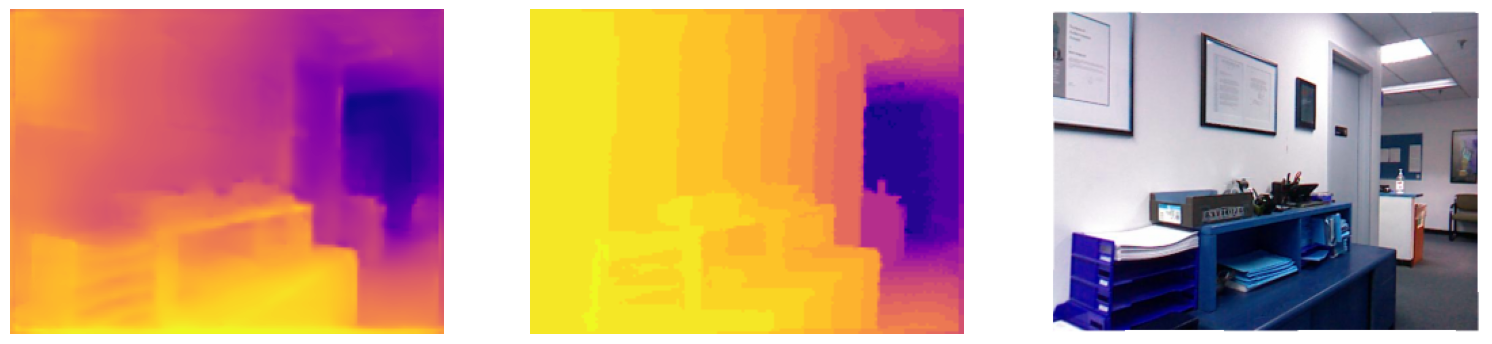

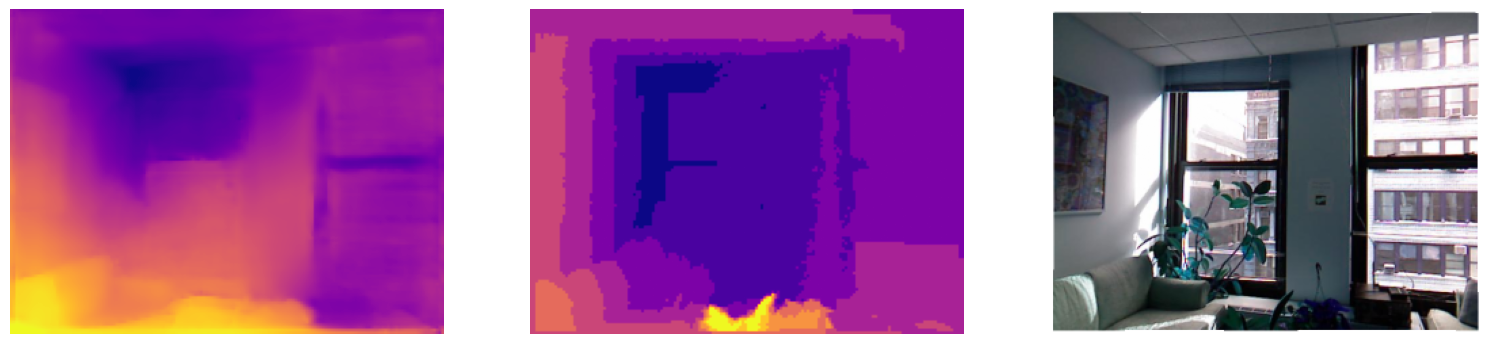

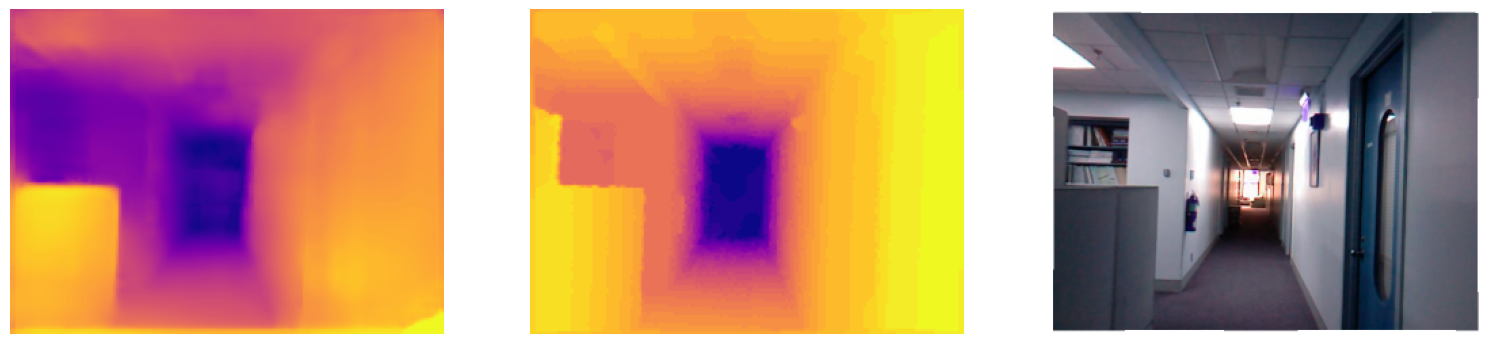

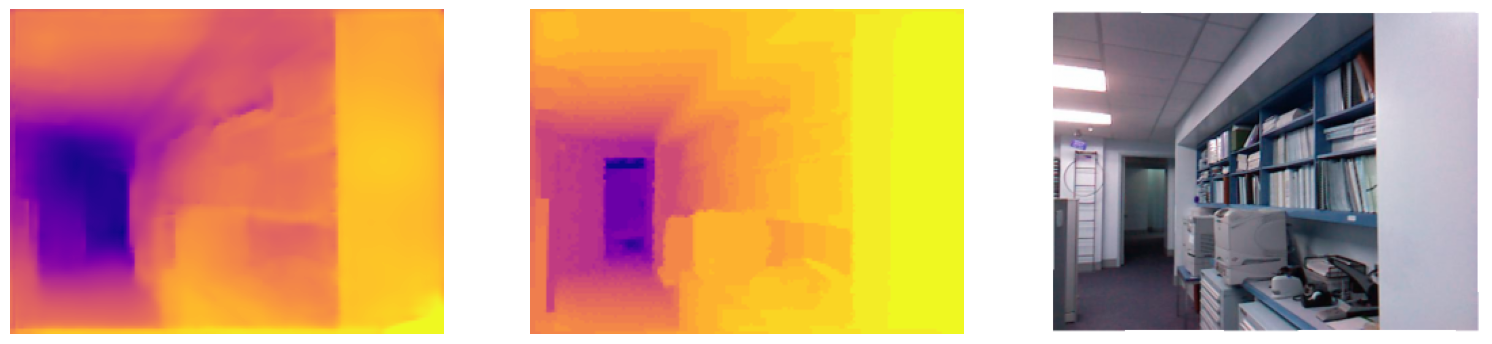

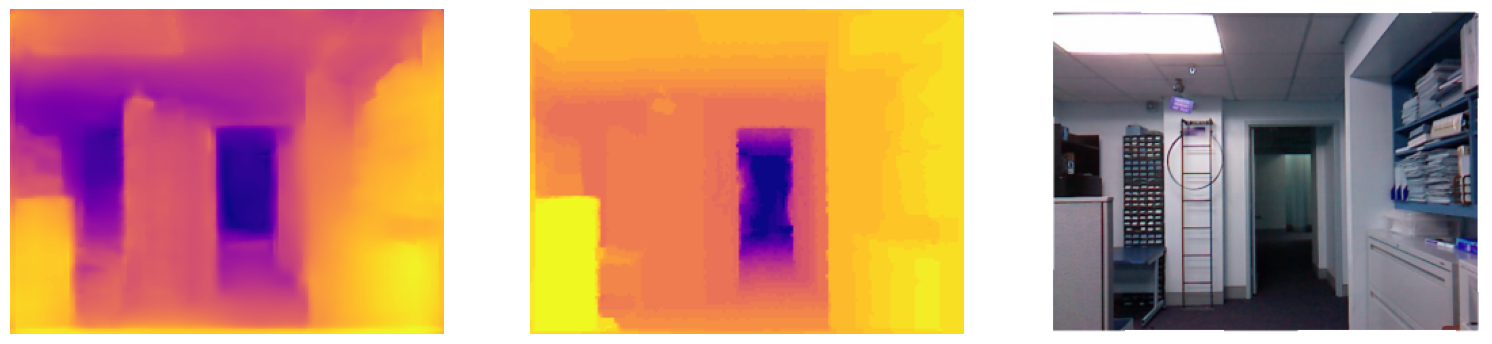

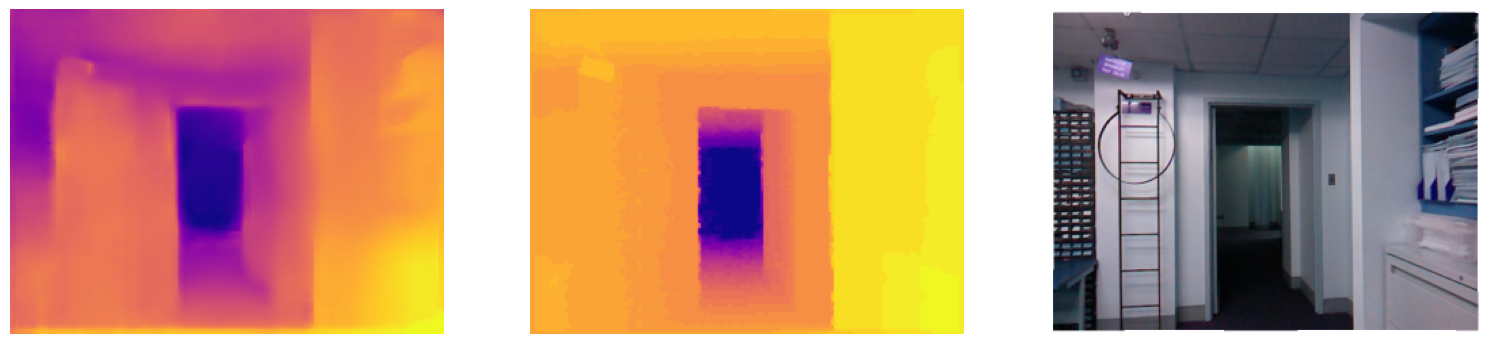

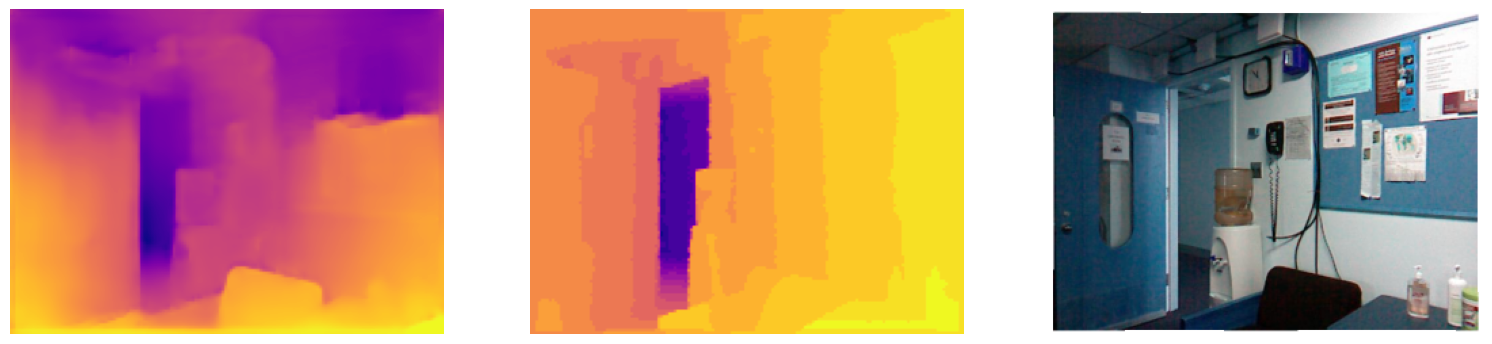

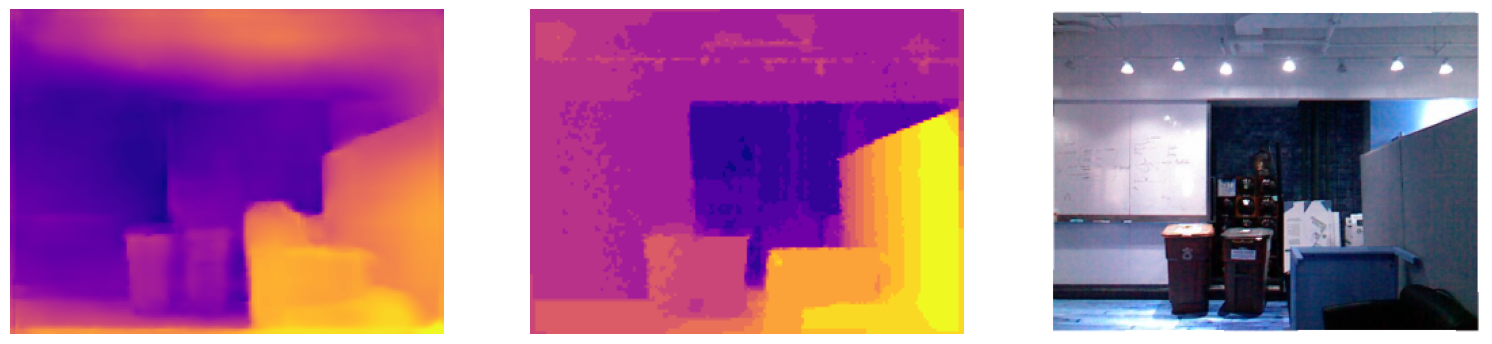

In [17]:
cmap = "plasma_r"
for i in range(len(images)):
    plt.figure(figsize=(19,10))
    pred = preds[i]
    pred = np.squeeze(pred, axis=-1)
    plt.subplot(1,3,1)
    plt.axis("off")
    plt.imshow(pred, cmap=plt.get_cmap(cmap))
    
    plt.subplot(1,3,2)
    plt.axis("off")
    img = labels[i]
    img = np.squeeze(img, axis=-1)
    plt.imshow(img, cmap=plt.get_cmap(cmap))

    plt.subplot(1,3,3)
    plt.axis("off")
    img1 = images[i]
    plt.imshow(img1)

    plt.show()

# Conversion and Optimization

In [18]:
saved_model_path = 'models/monocular-depth-estimation2.0'

## Float16 quantization

In [19]:
converted_model_path = 'models\monocular-depth-estimation2.0_fp16.tflite'
# Passing the baseline SavedModel to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

In [20]:
# Using float-16 quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [21]:
# Start conversion
tflite_model = converter.convert()

In [22]:
# Save the converted model
with open(converted_model_path, 'wb') as f:
    f.write(tflite_model)